# Overview
These analyses are separated into three main parts (see manuscript for description): characteristic, association, and conditional association. 

## Outputs
**(1) Characteristic, contingency tables:** 

1.1 Appendix. Contingency table with mean proportions and explicit uncertainty estimates obtained through DSL implementation (less interpretable than (1.2))

1.2 Main script. Contingency table with PRISM counts where cells with high levels of ucnertainty are greyed out (uncertainty calculated throguh DSL implementation)

**(2) Association, over-representation factors:**

2.1 Appendix. Bigger version of the figure from the main script, but this time including uncertainty estimates. 

2.2 Main script. Figure with over-representation factors using manual DSL implementation, again with high uncertainty estimates greyed out (SEs not included because of space). 

**(3) Conditional association, logistic regressions:**

3.1 Main script. Figure with log odds ratios from logistic regressions in panel A, and marginal effects in panel B. 

3.2 Appendix. Figure with predicted probabilities. 

**(4) Implement clustering technique** 

This was pre-registered, but is not included in the final report. See pre-registration accountability statement. 

## 0. Setup

In [1]:
##############################################
# Code implemented on:
# - Python Version: 3.11.11
# - Last modified: 09.08.2025
##############################################

################### Imports #################
import os
import re
import sys
import hdbscan
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from pandas import json_normalize 
from IPython.display import display
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from pdf2image import convert_from_path
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, LinearSegmentedColormap, to_rgba

################### Configs #################
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
sns.set()
np.random.seed(89)


################### Directory management #################
PROJECT_ROOT = "/Users/carolinewagner/Desktop/Local/MY498-capstone-main"
classified_path = os.path.join(PROJECT_ROOT, 
                               "01_data", 
                               "07_final_classified_data", 
                               "final_data_with_uncertainty.jsonl")

# Define the path to the ddesign-adjusted category proportions for 1.1 
dsl_proportions_path = os.path.join(
    PROJECT_ROOT,
    "01_data",
    "08_descriptive_results",
    "dsl_category_proportions.csv"
)

# New folder path for outputs
DESCRIPTIVE_ANALYSIS_DIR = os.path.join(PROJECT_ROOT, 
                                        "03_outputs", 
                                        "02_descriptive_analyses")

# Folder with helper functions
HELPER_DIR = os.path.join(PROJECT_ROOT, "02_code", "01_helper-functions")
sys.path.append(HELPER_DIR)



################### Load data #################
classified_data = pd.read_json(classified_path, lines=True)

#  Load DSL results 
dsl_results = pd.read_csv(dsl_proportions_path)


# For conditional associations part
# Import the results of the analyses that were computed in R, for visualisation in python. 

# Set your base directory (same as R's wdir)
wdir = "/Users/carolinewagner/Desktop/Local/MY498-capstone-main"

# Construct the path to the descriptive results directory
desdir = f"{wdir}/01_data/08_descriptive_results"

# Read in the exported tables
summary_table = pd.read_csv(f"{desdir}/logit_summary_table.csv")
prediction_table = pd.read_csv(f"{desdir}/prediction_table.csv")

# Load the marginal effects table exported from R
marginal_effects_table = pd.read_csv("/Users/carolinewagner/Desktop/Local/MY498-capstone-main/01_data/08_descriptive_results/marginal_effects_table.csv")


################### Source required functions #################
from general_python_helper import compute_orf

################### Set toggles #################
# Set the toggle below to True if you want the figures generates in this script to automatically 
# be saved ot the directory for descriptive analyses outputs defined above.
to_save = True 

In [ ]:
########################################
# Setup general data formatting for figures - used throughout
########################################

# (1) Figure formatting setups - fonts & colours 
matplotlib.rcParams['font.family'] = 'Arial'

# (a) general 
custom_color_codes = [
    "#B89038", "#702349", "#3C3C7A", "#356479", "#2F6B62", "#306630"
]
custom_colormaps = [
    LinearSegmentedColormap.from_list(f"custom_{i}", ["#ffffff", color], N=256)
    for i, color in enumerate(custom_color_codes)
]

# (b) For greying out the cells
flat_grey_cmap = LinearSegmentedColormap.from_list("FlatGrey", ["#b3b3b3", "#b3b3b3"])

# (c) For the totals rows in the contingency tables
grey_cmap = LinearSegmentedColormap.from_list("CustomGreys", ["#ffffff", "#e3e4e5", "#000000"])


# (2) Figure label cleaning and reordering
clean_qtype_labels = {
    "whether_q": "Whether",
    "which_q": "Which",
    "why_q": "Why",
    "whathow_q": "What/How",
    "hobsons_c": "Hobson's \nChoice"
}

# (3) Shared title mapping for subplot labels & shortened labels
subplot_titles = {
    "conversation_type": "Conversation Type",
    "gender": "Gender",
    "ethnicity_simplified": "Ethnicity",
    "religion_simplified": "Religious Affiliation",
    "location_special_region": "Birth Region",
    "education_recode": "Educational Experience"
}

group_label_map = {
    # Gender
    "non-binary / third gender": "Non-Binary / 3rd",

    # Location labels
    "australia and new zealand": "Australia & New Z.",
    "latin america and the caribbean": "Latam & Caribbean",
    "uk": "United Kingdom",
    "us": "United States",

    # Education labels
    "primary &/or secondary education": "Primary Education",
    "completed secondary school": "Completed Secondary",
    "some university but no degree": "Some University",
    "university bachelors degree": "Bachelor’s Degree",
    "graduate / professional degree": "Graduate/Professional",
    "vocational": "Vocational Training"
}

# (4) Defone row ordering for education
row_ordering = {
    "education_recode": [
        "primary &/or secondary education",
        "completed secondary school",
        "vocational",
        "some university but no degree",
        "university bachelors degree",
        "graduate / professional degree"
    ]
}

# (5) Define characteristics to be visualised
demo_cols = [
    'conversation_type', 
    'gender', 
    'ethnicity_simplified', 
    'religion_simplified', 
    'location_special_region',
    'education_recode'
]

# (6) Define labels for conditional association / log regs plots
# The order here differs from the other ones because of label length / overlap
demo_order = [
    "conversation_type", "age_group", "gender",
    "ethnicity_main", "religion_main", "birth_region",
    "education_recode"
]

label_map = {
    "conversation_type": "Conv. Type: ",
    "age_group": "Age: ",
    "gender": "Gender: ",
    "ethnicity_main": "Ethnicity: ",
    "religion_main": "Religion: ",
    "birth_region": "Birth Region: ",
    "education_recode": "Education: "
}

ref_texts = {
    "conversation_type": "Ref.\nUnguided",
    "age_group": "Ref.\n18–24",
    "gender": "Ref.\nMale",
    "ethnicity_main": "Ref.\nWhite",
    "religion_main": "Ref.\nNo Affiliation",
    "birth_region": "Ref.\nEurope",
    "education_recode": "Ref. Primary &/or\nSecondary Edu."
}

# 1. Characteristic, contingency tables

#### 1.1 Appendix. Contingency table with mean proportions and explicit uncertainty estimates obtained through DSL implementation (less interpretable than (1.2))

In [ ]:
########################################
# Setup & pre-processing for table 1.1
########################################

# (1) Configuration 
x_order = ["hobsons_c", "why_q", "whether_q", "which_q", "whathow_q"]
x_labels_clean = [clean_qtype_labels[q] for q in x_order]

# (2) Clean up invalid group values
dsl_results = dsl_results[~dsl_results["group"].isin(["NA", "Prefer not to say"])].copy()

# (3) Normalize DSL interrogative types 
dsl_results["question_type_clean"] = (
    dsl_results["question_type"].str.replace("design_adjusted_", "", regex=False).str.strip().str.lower()
)
dsl_results["demographic_clean"] = dsl_results["demographic"].str.strip().str.lower()
dsl_results["group_clean"] = dsl_results["group"].astype(str).str.strip().str.lower()

# (4) Build shared high-SE mask dictionary
high_se_mask_dict = {}
for _, row in dsl_results.iterrows():
    demo = row["demographic_clean"]
    group = row["group_clean"]
    qtype = row["question_type_clean"]
    est = row["Estimate"]
    se = row["Std.Error"]

    if pd.notna(est) and pd.notna(se) and abs(est) > 0.05:
        if se / abs(est) > 0.5:
            high_se_mask_dict[(demo, group, qtype)] = True

# (5) Reorganize DSL results into pivoted tables
contingency_tables_dsl = {}
for demo in demo_cols:
    demo_clean = demo.strip().lower()
    demo_df = dsl_results[dsl_results["demographic_clean"] == demo_clean].copy()
    if demo_df.empty:
        continue

    pivot_df = demo_df.pivot(index="group_clean", columns="question_type_clean", values="Estimate")
    pivot_df = pivot_df.reindex(columns=x_order).sort_index()
    proportions = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    contingency_tables_dsl[demo] = {"counts": pivot_df, "proportions": proportions}


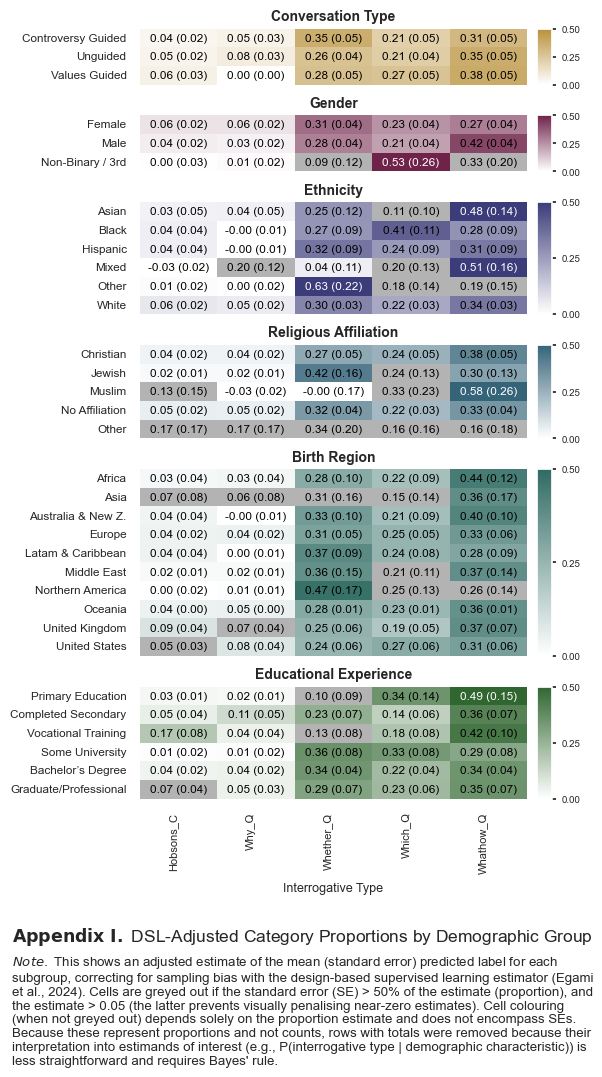

In [87]:
########################################
# DSL Heatmap Visualization w/ SEs — No Totals, Flat Grey for High-SE Cells
# Cells greyed out if SE > 50% of Estimate and Estimate > 0.05
########################################

# (1) Visualization setup
vmin, vmax = 0, 0.5
vmid = (vmin + vmax) / 2

target_width_in = 5
cell_height = 0.9
max_height_in = 11

subplot_heights = [contingency_tables_dsl[demo]['counts'].shape[0] for demo in demo_cols]
fig_height = min(sum([n * cell_height for n in subplot_heights]) + 2, max_height_in)

fig = plt.figure(figsize=(target_width_in, fig_height))
gs = GridSpec(len(demo_cols), 1, height_ratios=subplot_heights)

axes = []
heatmaps = []

# (2) Build SE lookup
se_lookup = dsl_results.set_index(["demographic_clean", "group_clean", "question_type_clean"])["Std.Error"].to_dict()

# (3) Plot
for i, demo in enumerate(demo_cols):
    counts = contingency_tables_dsl[demo]['counts']
    proportions = contingency_tables_dsl[demo]['proportions']

    # (a) Apply custom row ordering if available
    if demo in row_ordering:
        desired_order = row_ordering[demo]
        counts = counts.reindex(index=desired_order)
        proportions = proportions.reindex(index=desired_order)

    ax = plt.subplot(gs[i])
    axes.append(ax)
    ax.set_aspect("auto")

    cmap = custom_colormaps[i % len(custom_colormaps)]
    norm = Normalize(vmin=vmin, vmax=vmax)

    demo_key = demo.strip().lower()
    mask_high_se = pd.DataFrame(False, index=proportions.index, columns=proportions.columns)

    for row_key in proportions.index:
        group_key = str(row_key).strip().lower()
        for col_key in proportions.columns:
            qtype_key = str(col_key).strip().lower()
            if high_se_mask_dict.get((demo_key, group_key, qtype_key), False):
                mask_high_se.loc[row_key, col_key] = True

    # (b) main heatmap
    hm = sns.heatmap(
        proportions, cmap=cmap, ax=ax, cbar=False,
        vmin=vmin, vmax=vmax, annot=False, square=False, mask=mask_high_se
    )
    heatmaps.append(hm)

    # (c) Overlay grey for high-SE cells
    sns.heatmap(
        proportions, cmap=flat_grey_cmap, ax=ax, cbar=False,
        vmin=0, vmax=1, annot=False, square=False, mask=~mask_high_se
    )

    # (d) Text annotations
    for y, row_key in enumerate(proportions.index):
        group_key = str(row_key).strip().lower()
        for x, col_key in enumerate(proportions.columns):
            qtype_key = str(col_key).strip().lower()
            value = counts.loc[row_key, col_key]
            prop = proportions.loc[row_key, col_key]
            se = se_lookup.get((demo_key, group_key, qtype_key), None)

            text = f"{value:.2f} ({se:.2f})" if pd.notna(value) and se is not None else f"{value:.2f}"
            text_color = 'black' if prop < 0.5 else 'white'
            ax.text(x + 0.5, y + 0.5, text, ha='center', va='center', fontsize=8.5, color=text_color)

    # (e) Title and y-axis labels
    title = subplot_titles.get(demo, demo.replace("_simplified", "").replace("_", " ").title())
    ax.set_title(title, fontsize=10, pad=6, fontweight='semibold')
    ax.set_ylabel("")

    y_locs = np.arange(len(proportions.index)) + 0.5
    ax.set_yticks(y_locs)
    ax.set_yticklabels(
        [group_label_map.get(str(idx).lower(), str(idx).title()) for idx in proportions.index],
        rotation=0, fontsize=8.5
    )
    ax.yaxis.set_major_locator(FixedLocator(y_locs))
    ax.tick_params(axis='y', left=False)

    # (f) X-axis labels (only for last subplot)
    if i == len(demo_cols) - 1:
        ax.set_xticks(np.arange(len(proportions.columns)) + 0.5)
        ax.set_xticklabels(
            [clean_qtype_labels.get(col, col.title()) for col in proportions.columns],
            rotation=90, ha='right', fontsize=8
        )
        ax.set_xlabel("Interrogative Type", fontsize=9, labelpad=6)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.tick_params(axis='x', bottom=False)

# (4) Layout, bottom title, and colorbars
plt.subplots_adjust(hspace=0.3, top=0.94, bottom=0.24)  # add bottom space for texts
fig.canvas.draw()

# Bottom-centered title: bold prefix "Appendix I." then the existing title
bottom_title = r'$\bf{Appendix\ I.}$ DSL-Adjusted Category Proportions by Demographic Group'
plt.figtext(
    0.45, 0.11,  # a bit above the bottom edge
    bottom_title,
    ha='center',
    fontsize=12.5,
    fontfamily='Arial'
)

# Left-aligned brief note under the title
note_text = (
    "$\\it{Note.}$ This shows an adjusted estimate of the mean (standard error) predicted label for each subgroup, "
    "correcting for sampling bias with the design-based supervised learning estimator (Egami et al., 2024). "
    "Cells are greyed out if the standard error (SE) > 50% of the estimate (proportion), and the estimate > 0.05 "
    "(the latter prevents visually penalising near-zero estimates). "
    "Cell colouring (when not greyed out) depends solely on the proportion estimate and does not encompass SEs. "
    "Because these represent proportions and not counts, rows with totals were removed because their interpretation "
    "into estimands of interest (e.g., P(interrogative type | demographic characteristic)) is less straightforward "
    "and requires Bayes' rule."
)

plt.figtext(
    -0.13, 0,            
    note_text,
    ha='left',
    fontsize=9.5,
    fontfamily='Arial',
    linespacing=1.15,
    wrap=True
)

# Colorbars (unchanged, but keep them after fig.canvas.draw())
cbar_width = 0.03
fixed_cbar_x = 0.92
for ax, hm in zip(axes, heatmaps):
    bbox = ax.get_position()
    cbar_ax = fig.add_axes([fixed_cbar_x, bbox.y0, cbar_width, bbox.height])
    cbar = fig.colorbar(hm.get_children()[0], cax=cbar_ax, orientation='vertical')
    cbar.set_ticks([vmin, vmid, vmax])
    cbar.set_ticklabels([f"{vmin:.2f}", f"{vmid:.2f}", f"{vmax:.2f}"])
    cbar.ax.tick_params(labelsize=7, length=3)

# (5) Save
if to_save:
    output_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "appendix_i.pdf")
    fig.savefig(output_path, dpi=300, bbox_inches='tight', transparent=False)

plt.show()


#### 1.2 Main script. Contingency table with PRISM counts where cells with high levels of ucnertainty are greyed out (uncertainty calculated throguh DSL implementation)
Please note that the formatting and logic of these analyses follows case study 1 by Kirk et al. (2024, pp.6-7). 


In [108]:
########################################
# Implement contingency table analyses
########################################

# Compute the counts that will go into the contingency table. 

# (1) Define question types (Defined separately here because using design-adjusted outcomes)
qtype_cols = [
    "design_adjusted_hobsons_c",
    "design_adjusted_why_q",
    "design_adjusted_whether_q",
    "design_adjusted_which_q",
    "design_adjusted_whathow_q"
]

clean_qtype_labels = {
    "design_adjusted_whether_q": "Whether",
    "design_adjusted_which_q": "Which",
    "design_adjusted_why_q": "Why",
    "design_adjusted_whathow_q": "What/How",
    "design_adjusted_hobsons_c": "Hobson's \nChoice"
}


# (2) Melt the data
melted = classified_data.melt(
    id_vars=demo_cols,
    value_vars=qtype_cols,
    var_name='question_type',
    value_name='is_present'
)
melted = melted[melted['is_present'] == 1]

# (3) Prepare one big nested dictionary of contingency tables
contingency_tables = {}

for demo in demo_cols:
    plot_df = melted[
        melted[demo].notna() & (melted[demo] != "Prefer not to say")
    ].copy()

    # (a) Sort and reindex demo variable
    unique_vals = sorted([x for x in plot_df[demo].unique() if x != 'Other'])
    if "Other" in plot_df[demo].unique():
        unique_vals.append("Other")
    plot_df[demo] = pd.Categorical(plot_df[demo], categories=unique_vals, ordered=True)

    grouped = plot_df.groupby([demo, 'question_type'], observed=True).size().unstack(fill_value=0)
    grouped = grouped[qtype_cols].reindex(unique_vals)

    # (b) Add total row and column
    grouped_with_total = grouped.copy()
    grouped_with_total.loc['Total'] = grouped.sum()
    grouped_with_total['Total'] = grouped_with_total.sum(axis=1)

    # (c) Store both raw and proportional values
    proportions = grouped_with_total.div(grouped_with_total.sum(axis=1), axis=0)

    contingency_tables[demo] = {
        "counts": grouped_with_total,
        "proportions": proportions
    }


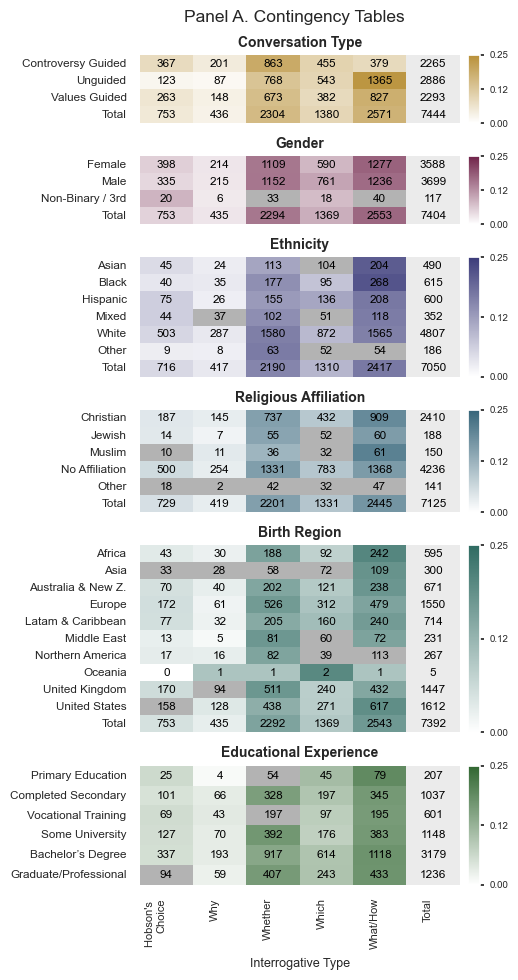

In [46]:
########################################
# Visualise contingency tables for main manuscript
########################################

# (1) Build grey-mask lookup based on SE/Estimate thresholds
high_se_mask_dict = {}
for _, row in dsl_results.iterrows():
    demo = str(row["demographic"]).strip().lower()
    group = str(row["group"]).strip().lower()
    qtype = str(row["question_type"]).strip().lower().replace("design_adjusted_", "")
    est = row["Estimate"]
    se = row["Std.Error"]

    if pd.notna(est) and pd.notna(se) and abs(est) > 0.05:
        if se / abs(est) > 0.5:
            high_se_mask_dict[(demo, group, qtype)] = True

vmin, vmax = 0, 0.25
vmid = (vmin + vmax) / 2

# (2) Layout control
target_width_in = 4.13
cell_height = 0.9
max_height_in = 10

subplot_heights = [contingency_tables[demo]['counts'].shape[0] for demo in demo_cols]
fig_height = min(sum([n * cell_height for n in subplot_heights]) + 2, max_height_in)

fig = plt.figure(figsize=(target_width_in, fig_height))
gs = GridSpec(len(demo_cols), 1, height_ratios=subplot_heights)

# (3) Draw heatmaps
axes = []
heatmaps = []

for i, demo in enumerate(demo_cols):
    counts = contingency_tables[demo]['counts']
    proportions = contingency_tables[demo]['proportions']

    # (a) Apply row ordering if defined
    if demo in row_ordering:
        desired_order = row_ordering[demo]
        counts.index = counts.index.str.lower()
        proportions.index = proportions.index.str.lower()
        counts = counts.reindex(index=desired_order)
        proportions = proportions.reindex(index=desired_order)

    ax = plt.subplot(gs[i])
    axes.append(ax)
    ax.set_aspect("auto")

    cmap = custom_colormaps[i % len(custom_colormaps)]
    norm = Normalize(vmin=vmin, vmax=vmax)

    # (b) Create high-SE mask only
    mask_high_se = pd.DataFrame(False, index=counts.index, columns=counts.columns)

    demo_key = str(demo).strip().lower()
    for row_key in counts.index:
        group_key = str(row_key).strip().lower()
        for col_key in counts.columns:
            qtype_key = str(col_key).strip().lower().replace("design_adjusted_", "")
            if high_se_mask_dict.get((demo_key, group_key, qtype_key), False):
                mask_high_se.loc[row_key, col_key] = True

    # (c) Main heatmap (non-grey)
    hm = sns.heatmap(
        proportions,
        cmap=cmap,
        ax=ax,
        cbar=False,
        vmin=vmin,
        vmax=vmax,
        annot=False,
        square=False,
        mask=mask_high_se
    )
    heatmaps.append(hm)

    # (d) Overlay grey for high-SE cells
    sns.heatmap(
        proportions,
        cmap=flat_grey_cmap,
        ax=ax,
        cbar=False,
        vmin=0,
        vmax=1,
        annot=False,
        square=False,
        mask=~mask_high_se
    )

    # (e) Overlay white background for "Total" column cells
    for y, row_key in enumerate(proportions.index):
        for x, col_key in enumerate(proportions.columns):
            if str(col_key).lower() == "total":
                ax.add_patch(
                    plt.Rectangle((x, y), 1, 1, color="#ebebeb", zorder=3, linewidth=0) 
                )

    # (f) Text annotations (all cells)
    for y, row_key in enumerate(proportions.index):
        for x, col_key in enumerate(proportions.columns):
            value = counts.loc[row_key, col_key]
            prop = proportions.loc[row_key, col_key]
            text_color = 'black'  # optional logic can go here
            ax.text(x + 0.5, y + 0.5, str(value), ha='center', va='center',
                    fontsize=8.5, color=text_color)

    # (g) Titles and labels
    title = subplot_titles.get(demo, demo.replace("_simplified", "").replace("_", " ").title())
    ax.set_title(title, fontsize=10, pad=6, fontweight='semibold')
    ax.set_ylabel("")

    y_locs = np.arange(len(proportions.index)) + 0.5
    ax.set_yticks(y_locs)
    ax.set_yticklabels(
        [group_label_map.get(str(idx).lower(), str(idx).title()) for idx in proportions.index],
        rotation=0, fontsize=8.5
    )
    ax.yaxis.set_major_locator(FixedLocator(y_locs))
    ax.tick_params(axis='y', left=False)

    if i == len(demo_cols) - 1:
        clean_labels = [clean_qtype_labels[q] for q in qtype_cols] + ['Total']
        ax.set_xticks(np.arange(len(clean_labels)) + 0.5)
        ax.set_xticklabels(clean_labels, rotation=90, ha='right', fontsize=8)
        ax.set_xlabel("Interrogative Type", fontsize=9, labelpad=6)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.tick_params(axis='x', bottom=False)

# (4) Final layout and colorbars
plt.subplots_adjust(hspace=0.3, top=0.94)
fig.suptitle("Panel A. Contingency Tables", fontsize=12.5, y=0.985)
fig.canvas.draw()

cbar_width = 0.03
fixed_cbar_x = 0.92

for ax, hm in zip(axes, heatmaps):
    bbox = ax.get_position()
    cbar_ax = fig.add_axes([fixed_cbar_x, bbox.y0, cbar_width, bbox.height])
    cbar = fig.colorbar(hm.get_children()[0], cax=cbar_ax, orientation='vertical')
    cbar.set_ticks([vmin, vmid, vmax])
    cbar.set_ticklabels([f"{vmin:.2f}", f"{vmid:.2f}", f"{vmax:.2f}"])
    cbar.ax.tick_params(labelsize=7, length=3)

# (5) Save and display
if to_save:
    output_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_1_panel_A.pdf")
    fig.savefig(output_path, dpi=300, bbox_inches='tight', transparent=False)

plt.show()

In [ ]:
# Note. 
#This heatmap displays PRISM opening prompts classified in terms of interrogative types across demographic groups based on 8,002 prompts. 
#The total number of prompts does not reflect the full dataset due to the exclusion of prompts with missing data, unclassified inputs (n = 172), 
# and responses where participants selected “Prefer not to say.” Each participant contributed multiple prompts (on average, four), so individual 
# participants are represented multiple times in the table. The interrogative types (columns) are ordered from left to right in increasing degrees 
# of selection specificity, although this progression is not strictly linear. Note that the coloring emphasizes within-row (group-wise) comparisons and 
# legends reflect row-normalized proportions.

## (2) Association, over-representation factors:

In [48]:
########################################
# Setup for design-adjusted outcomes and compute ORF
########################################

# (0) Define question and demographic variables
qtype_cols = [
    "design_adjusted_hobsons_c",
    "design_adjusted_why_q",
    "design_adjusted_whether_q",
    "design_adjusted_which_q",
    "design_adjusted_whathow_q"
]

clean_qtype_labels = {
    "design_adjusted_whether_q": "Whether",
    "design_adjusted_which_q": "Which",
    "design_adjusted_why_q": "Why",
    "design_adjusted_whathow_q": "What/How",
    "design_adjusted_hobsons_c": "Hobson's\nChoice"
}

n_boot = 1000
orf_tables = []
orf_se_tables = []
orf_display_tables = []


# (1) Compute ORFs and Bootstrap SEs
for demo_col in demo_cols:
    df = classified_data[classified_data[demo_col].notna() & (classified_data[demo_col] != "Prefer not to say")].copy()

    # (2) Base ORF table
    base_orf = compute_orf(df, demo_col, qtype_cols, clean_qtype_labels).round(2).fillna(np.nan)
    orf_tables.append((demo_col, base_orf))

    # (3) Bootstrap samples
    boot_orfs = [
        compute_orf(df.sample(frac=1, replace=True), demo_col, qtype_cols, clean_qtype_labels)
        for _ in range(n_boot)
    ]
    boot_concat = pd.concat(boot_orfs, keys=range(n_boot))
    se_table = boot_concat.groupby(level=1).std().round(2).reindex(base_orf.index)
    orf_se_tables.append((demo_col, se_table))

    # (4) Combine into formatted string table
    combined_df = base_orf.copy()
    for col in combined_df.columns:
        combined_df[col] = [
            f"{m:.2f} ({s:.2f})" if pd.notna(m) and pd.notna(s) else ""
            for m, s in zip(base_orf[col], se_table[col])
        ]
    orf_display_tables.append((demo_col, combined_df))


#### 2.1 Appendix. Bigger version of the figure from the main script, but this time including uncertainty estimates. 

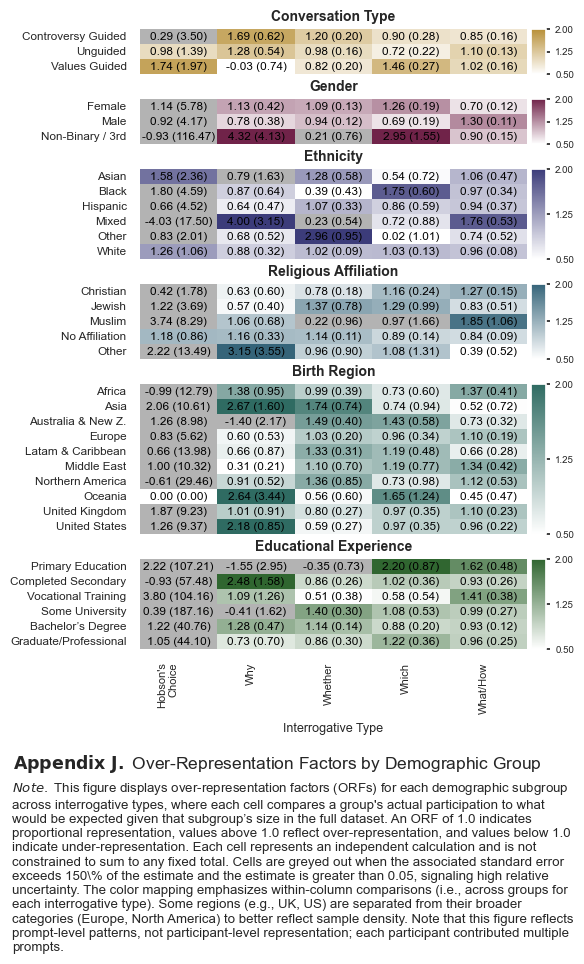

In [72]:
########################################
# Implement ORF figure with DSL outcome for appendix
########################################

# (1) Heatmap settings
vmin, vmax = 0.5, 2
vmid = (vmin + vmax) / 2
cell_height = 0.9
target_width_in = 5
max_height_in = 10

# (2) Figure layout
heights = [len(tbl.index) for _, tbl in orf_tables]
fig_height = min(sum([n * cell_height for n in heights]) + 1.5, max_height_in)
fig = plt.figure(figsize=(target_width_in, fig_height))
gs = GridSpec(len(demo_cols), 1, height_ratios=heights)
ax_refs = []
colorbar_refs = []

# (3) Plot each panel 
for i, ((demo_col, orf_df), (_, display_df), (_, se_df)) in enumerate(zip(orf_tables, orf_display_tables, orf_se_tables)):
    ax = plt.subplot(gs[i])
    ax_refs.append(ax)
    ax.set_aspect("auto")

    # (a) Remove "Prefer Not To Say"
    keep_rows = ~orf_df.index.str.contains("Prefer Not To Say", case=False, na=False)
    orf_df = orf_df[keep_rows]
    display_df = display_df[keep_rows]
    se_df = se_df[keep_rows]

    # (b) Apply row ordering if defined
    if demo_col in row_ordering:
        orf_df.index = orf_df.index.str.lower()
        display_df.index = display_df.index.str.lower()
        se_df.index = se_df.index.str.lower()
        orf_df = orf_df.reindex(row_ordering[demo_col])
        display_df = display_df.reindex(row_ordering[demo_col])
        se_df = se_df.reindex(row_ordering[demo_col])

    # (c) Normalize and color mapping
    cmap = custom_colormaps[i % len(custom_colormaps)]
    norm = Normalize(vmin=vmin, vmax=vmax)
    color_values = norm(orf_df)
    rgba_colors = cmap(color_values)

    # (d) Grey-out cells with high SE
    grey_rgba = to_rgba("#b3b3b3")
    mask_high_se = (se_df.abs() / orf_df.abs() > 1.5) & (orf_df.abs() > 0.05)
    for r in range(rgba_colors.shape[0]):
        for c in range(rgba_colors.shape[1]):
            if mask_high_se.iloc[r, c]:
                rgba_colors[r, c] = grey_rgba

    # (e) Plot heatmap structure
    sns.heatmap(
        orf_df,
        annot=display_df,
        fmt="",
        cmap=cmap,
        norm=norm,
        cbar=False,
        ax=ax,
        linewidths=0,
        linecolor='white',
        annot_kws={"size": 8.5, "color": "black"},
        mask=None,
        square=False,
        xticklabels=True,
        yticklabels=True
    )

    # (f) Remove default tiles and add custom colored cells
    ax.collections[0].remove()
    ax.pcolormesh(rgba_colors, edgecolors='white', linewidth=0)

    # (g) Subplot title
    title = subplot_titles.get(demo_col, demo_col.replace("_simplified", "").replace("_", " ").title())
    ax.set_title(title, fontsize=10, pad=6, fontweight='semibold')
    ax.set_ylabel("")

    # (h) Y-tick formatting
    yticks = np.arange(len(orf_df.index)) + 0.5
    ax.set_yticks(yticks)
    ax.set_yticklabels(
        [group_label_map.get(str(idx).lower(), str(idx).title()) for idx in orf_df.index],
        fontsize=8.5, rotation=0
    )
    ax.tick_params(axis='y', left=False)

    # (i) X-tick formatting
    if i == len(demo_cols) - 1:
        clean_labels = [clean_qtype_labels[q] for q in qtype_cols]
        xticks = np.arange(len(clean_labels)) + 0.5
        ax.set_xticks(xticks)
        ax.set_xticklabels(clean_labels, rotation=90, ha='right', fontsize=8)
        ax.set_xlabel("Interrogative Type", fontsize=9, labelpad=6)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.tick_params(axis='x', bottom=False)
 
# (4) Layout, bottom title, and note (match Appendix I style)
plt.subplots_adjust(hspace=0.3, top=0.94, bottom=0.32)  # leave more bottom space for long note
fig.canvas.draw()

# Bottom-centered title with bold "Appendix J."
bottom_title = r'$\bf{Appendix\ J.}$ Over-Representation Factors by Demographic Group'
plt.figtext(
    0.4, 0.2,  # horizontal & vertical position of title
    bottom_title,
    ha='center',
    fontsize=12.5,
    fontfamily='Arial'
)

# Left-aligned detailed note with italic "Note."
note_text = (
    r"$\it{Note.}$ This figure displays over-representation factors (ORFs) for each demographic subgroup across interrogative types, "
    r"where each cell compares a group's actual participation to what would be expected given that subgroup’s size in the full dataset. "
    r"An ORF of 1.0 indicates proportional representation, values above 1.0 reflect over-representation, and values below 1.0 "
    r"indicate under-representation. Each cell represents an independent calculation and is not constrained to sum to any fixed total. "
    r"Cells are greyed out when the associated standard error exceeds 150\% of the estimate and the estimate is greater than 0.05, "
    r"signaling high relative uncertainty. The color mapping emphasizes within-column comparisons (i.e., across groups for each interrogative type). "
    r"Some regions (e.g., UK, US) are separated from their broader categories (Europe, North America) to better reflect sample density. "
    r"Note that this figure reflects prompt-level patterns, not participant-level representation; each participant contributed multiple prompts."
)
plt.figtext(
    -0.13, 0.02,  # position: left-aligned & just below title
    note_text,
    ha='left',
    fontsize=9.5,
    fontfamily='Arial',
    linespacing=1.2,
    wrap=True
)

# (5) Add aligned colorbars
cbar_width = 0.03
cbar_pad = 0.008
fixed_cbar_x = max(ax.get_position().x1 for ax in ax_refs) + cbar_pad

for i, ax in enumerate(ax_refs):
    cmap = custom_colormaps[i % len(custom_colormaps)]
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    bbox = ax.get_position()
    cbar_ax = fig.add_axes([
        fixed_cbar_x,
        bbox.y0,
        cbar_width,
        bbox.height
    ])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.set_ticks([vmin, vmid, vmax])
    cbar.set_ticklabels([f"{vmin:.2f}", f"{vmid:.2f}", f"{vmax:.2f}"])
    cbar.ax.tick_params(labelsize=7, length=3)

# (6) Save & show 
if to_save:
    save_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "appendix_j.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


#### 2.2 Main script. Figure with over-representation factors using manual DSL implementation, again with high uncertainty estimates greyed out (SEs not included because of space). 

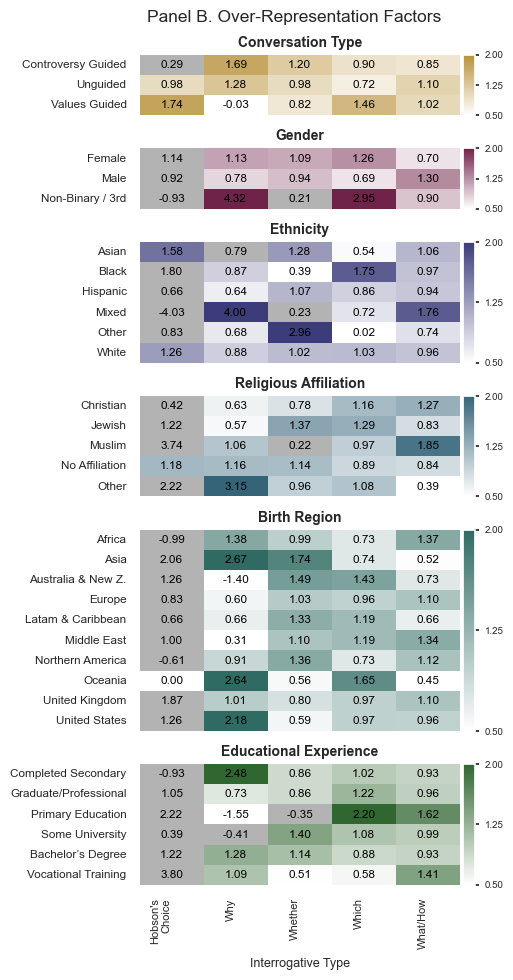

In [129]:
########################################
# Implement ORF figure with DSL outcome for main script 
########################################

# (1) Layout control 
vmin, vmax = 0.5, 2
vmid = (vmin + vmax) / 2
target_width_in = 4.13
cell_height = 0.9
max_height_in = 10
cbar_width = 0.03
cbar_pad = 0.008

# (2) Calculate subplot heights based on row counts
subplot_heights = [len(tbl.index) for _, tbl in orf_tables]
fig_height = min(sum([n * cell_height for n in subplot_heights]) + 1.5, max_height_in)

# (3) Create figure and gridspec
fig2 = plt.figure(figsize=(target_width_in, fig_height))
gs2 = GridSpec(len(demo_cols), 1, height_ratios=subplot_heights)
ax_refs2 = []

# (4) Plot each heatmap
for i, ((demo_col, orf_df), (_, _), (_, se_df)) in enumerate(zip(orf_tables, orf_display_tables, orf_se_tables)):
    ax = plt.subplot(gs2[i])
    ax_refs2.append(ax)
    ax.set_aspect("auto")

    # (a) Filter out 'Prefer Not To Say'
    keep_rows = ~orf_df.index.str.contains("Prefer Not To Say", case=False, na=False)
    orf_df = orf_df[keep_rows]
    se_df = se_df[keep_rows]

    # (b) Normalize and colormap 
    cmap = custom_colormaps[i % len(custom_colormaps)]
    norm = Normalize(vmin=vmin, vmax=vmax)
    color_values = norm(orf_df)
    rgba_colors = cmap(color_values)

    # (c) Grey-out high-SE cells 
    grey_rgba = to_rgba("#b3b3b3")
    mask_high_se = (se_df.abs() / orf_df.abs() > 2) & (orf_df.abs() > 0.05)
    for r in range(rgba_colors.shape[0]):
        for c in range(rgba_colors.shape[1]):
            if mask_high_se.iloc[r, c]:
                rgba_colors[r, c] = grey_rgba

    # (d) Format annotations
    formatted_annot = orf_df.copy()
    for col in formatted_annot.columns:
        formatted_annot[col] = formatted_annot[col].map(lambda x: f"{x:.2f}")

    # (e) Base heatmap for structure
    sns.heatmap(
        orf_df,
        annot=formatted_annot,
        fmt="",
        cmap=cmap,
        norm=norm,
        cbar=False,
        ax=ax,
        linewidths=0,
        linecolor='white',
        annot_kws={"size": 8.5, "color": "black"},
        mask=None,
        square=False,
        xticklabels=True,
        yticklabels=True
    )

    # (f) Overlay custom color tiles with consistent cell size
    ax.collections[0].remove()
    ax.pcolormesh(rgba_colors, edgecolors='white', linewidth=0)

    # (g) Titles and tick formatting
    title = subplot_titles.get(demo_col, demo_col.replace("_simplified", "").replace("_", " ").title())
    ax.set_title(title, fontsize=10, pad=6, fontweight='semibold')
    ax.set_ylabel("")

    y_locs = np.arange(len(orf_df.index)) + 0.5
    ax.set_yticks(y_locs)
    ax.set_yticklabels(
        [group_label_map.get(str(idx).lower(), str(idx).title()) for idx in orf_df.index],
        fontsize=8.5, rotation=0
    )
    ax.tick_params(axis='y', left=False)

    if i == len(demo_cols) - 1:
        clean_labels = [clean_qtype_labels[q] for q in qtype_cols]
        xticks = np.arange(len(clean_labels)) + 0.5
        ax.set_xticks(xticks)
        ax.set_xticklabels(clean_labels, rotation=90, ha='right', fontsize=8)
        ax.set_xlabel("Interrogative Type", fontsize=9, labelpad=6)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.tick_params(axis='x', bottom=False)

# (5) Final layout and title
plt.subplots_adjust(hspace=0.3, top=0.94)
fig2.suptitle("Panel B. Over-Representation Factors", fontsize=12.5, y=0.985)
fig2.canvas.draw()

# (6) Aligned colorbars next to each subplot
fixed_cbar_x2 = max(ax.get_position().x1 for ax in ax_refs2) + cbar_pad

for i, ax in enumerate(ax_refs2):
    cmap = custom_colormaps[i % len(custom_colormaps)]
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    bbox = ax.get_position()
    cbar_ax = fig2.add_axes([
        fixed_cbar_x2,
        bbox.y0,
        cbar_width,
        bbox.height
    ])
    cbar = fig2.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.set_ticks([vmin, vmid, vmax])
    cbar.set_ticklabels([f"{vmin:.2f}", f"{vmid:.2f}", f"{vmax:.2f}"])
    cbar.ax.tick_params(labelsize=7, length=3)

# (7) Save or display
if to_save:
    save_path2 = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_1_panel_B.pdf")
    plt.savefig(save_path2, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
########################################
# Stats to walk reader through example in manuscript 
# For: Completed Secondary School & What/How
########################################

demo_col = "education_recode"
target = "Completed Secondary School"
q_col = "design_adjusted_whathow_q"

# (1) Filter valid data
df_ = df[df[demo_col].notna() & (df[demo_col] != "Prefer not to say")]

# (2) Compute components
weights = df_[q_col]
N_gi = weights[df_[demo_col] == target].sum()
N_i = weights.sum()
N_g = (df_[demo_col] == target).sum()
N_total = len(df_)

# (3) ORF calculation
obs = N_gi / N_i
exp = N_g / N_total
orf = obs / exp

print(f"Observed: {obs:.3f}")
print(f"Expected: {exp:.3f}")
print(f"ORF: {orf:.2f}")

Observed: 0.129
Expected: 0.139
ORF: 0.93


In [27]:
########################################
# Combine two PDFs side by side + add bottom title & italic note
########################################

# (1) Inputs 
fig_a_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_1_panel_A.pdf")
fig_b_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_1_panel_B.pdf")
combined_pdf_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_1.pdf")

# (2) Poppler path if needed
poppler_path = os.environ.get("POPPLER_PATH", None)  # e.g., "/opt/homebrew/opt/poppler/bin"

# (3) Convert PDFs to images at 300 DPI 
kwargs = {"dpi": 300}
if poppler_path:
    kwargs["poppler_path"] = poppler_path

img_a = convert_from_path(fig_a_path, **kwargs)[0]
img_b = convert_from_path(fig_b_path, **kwargs)[0]

#  (4) Match heights 
target_h = max(img_a.height, img_b.height)

def _resize_to_height(im, h):
    w = int(im.width * (h / im.height))
    return im.resize((w, h), Image.LANCZOS)

img_a = _resize_to_height(img_a, target_h)
img_b = _resize_to_height(img_b, target_h)

# (5) Concatenate with gutter 
gutter_px = 1
combined_w = img_a.width + gutter_px + img_b.width
combined_h = target_h

combined = Image.new("RGB", (combined_w, combined_h), "white")
combined.paste(img_a, (0, 0))
combined.paste(img_b, (img_a.width + gutter_px, 0))

# (6) Wrap in Matplotlib to add bottom title & note 
dpi = 300
bottom_margin_in = 2.8  # space for title + note
fig_w_in = combined_w / dpi
fig_h_in = combined_h / dpi + bottom_margin_in

fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=dpi)
ax.axis("off")

# (7) Image placement
img_top = bottom_margin_in / fig_h_in
img_height = (combined_h / dpi) / fig_h_in
ax_img = fig.add_axes([0, img_top, 1, img_height])
ax_img.axis("off")
ax_img.imshow(combined)

# (8) Titles
left_x = ax_img.get_position().x0

figure_title = r"$\bf{Figure\ 1.}$ Distribution and Over-Representation of Interrogative Types Across Explanatory Variables (Study 1)"
plt.figtext(
    left_x, 0.18,  # lower y-value (0.16) and aligned to Panel A
    figure_title,
    ha="left",
    va="bottom",
    fontsize=12.5,
    fontfamily="Arial"
)


# (9) Note
note_text = (
    r"$\it{Note.}$ Panel A shows PRISM opening prompts (n = 8,002) classified into interrogative types across demographic groups, "
    "excluding prompts with missing data, and unclassified inputs. Each participant "
    "could contribute multiple prompts (mean ≈ 4). Colors emphasize within-row proportions. "
    "Panel B shows over-representation factors (ORFs): each subgroup’s observed proportion for an interrogative type compared "
    "to the expected proportion given the subgroup’s size (ORF = 1 indicates proportional representation). "
    "Cells are greyed out when uncertainty is high (SE > 50% of the estimate in Panel A; SE > 150% in Panel B - the threshold in Panel B is higher because estimates are more conservative). See Appendices I & J for full uncertainty estimates."
)
plt.figtext(
    0.0, 0.065,  # left aligned
    note_text,
    ha="left",
    va="bottom",
    fontsize=12,        # increased from 11 → 12 for larger text
    linespacing=1.5,    # add ~20% extra spacing between lines
    fontfamily="Arial",
    wrap=True
)



# (10) Save final pdf
fig.savefig(combined_pdf_path, bbox_inches="tight", dpi=dpi)
plt.close(fig)

print(f"Saved combined PDF to: {combined_pdf_path}")


Saved combined PDF to: /Users/carolinewagner/Desktop/Local/MY498-capstone-main/03_outputs/02_descriptive_analyses/figure_1.pdf


# (3) Conditional association, logistic regressions:
The logistic regressions were implemented in R; the code for them can be found under the file .../02_code/07_descriptive_log_regs.Rmd in the same repository where the present file is. 

#### 3.1 Main script. Figure with log odds ratios from logistic regressions in panel A, and marginal effects in panel B. 


In [19]:
########################################
# Setup
########################################
# Visualises the results of the logistic regression analyses that were computed in R. 

# (1) Exactly the same rows as in Kirk et al. are dropped
terms_to_drop = [
    "genderPrefer not to say",
    "birth_regionOceania",
    "birth_regionPrefer not to say"
]

# (2) Filter out unwanted terms
summary_table = summary_table[~summary_table["term"].isin(terms_to_drop)]

# (3) Clean data 
summary_table = summary_table[summary_table["term"] != "(Intercept)"]
summary_table["significant_99pc"] = summary_table["adj_p"] < 0.01

# (4) Remove "prefer not to say" - otherwise groups too small induce visual bias in the figures 
summary_table = summary_table[~summary_table["term"].str.contains("prefer not to say", case=False, na=False)]

# (5) Pivot 
heatmap_data = summary_table.pivot(index="term", columns="outcome", values="estimate")
significance_data = summary_table.pivot(index="term", columns="outcome", values="significant_99pc")
annotations = significance_data.copy()
for col in annotations.columns:
    annotations[col] = annotations[col].map({True: "*", False: ""})

# (6) Sort and clean labels 
ordered_terms = list(OrderedDict.fromkeys(
    [term for group in demo_order for term in heatmap_data.index if term.startswith(group)]
))
heatmap_data = heatmap_data.loc[ordered_terms]
annotations = annotations.loc[ordered_terms]

clean_labels, demo_prefixes = [], []
for term in heatmap_data.index:
    for prefix, label in label_map.items():
        if term.startswith(prefix):
            val = term.replace(prefix, "").replace("_", " ").strip().lower()
            pretty_val = group_label_map.get(val, val.title())
            clean_labels.append(f"{label}{pretty_val}")
            demo_prefixes.append(prefix)
            break
heatmap_data.index = clean_labels
annotations.index = clean_labels


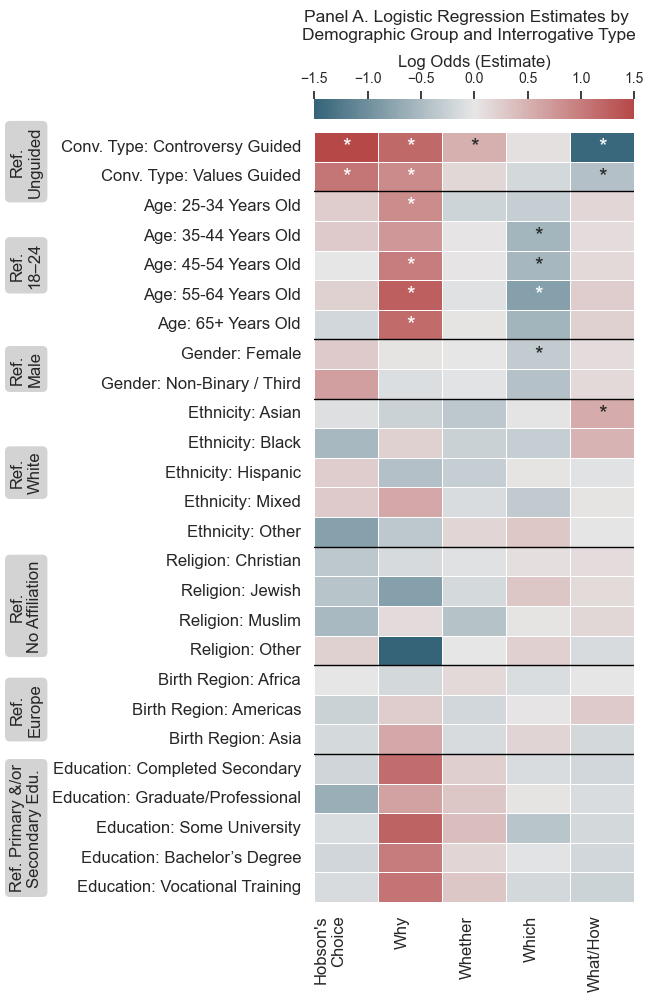

In [ ]:
########################################
# Plot the results
########################################

#  (1) Reorder X 
x_order = ["hobsons_c", "why_q", "whether_q", "which_q", "whathow_q"]
x_labels_clean = ["Hobson's\nChoice", "Why", "Whether", "Which", "What/How"]
heatmap_data = heatmap_data[x_order]
annotations = annotations[x_order]

# (2) Define custom diverging colormap
custom_div_cmap = LinearSegmentedColormap.from_list(
    "custom_diverging", ["#356479", "#e7e7e7", "#B64747"], N=256
)


#  (3) Layout control 
target_width_in = 4.13
cell_height = 0.9
max_height_in = 10
fig_height = min(len(heatmap_data.index) * cell_height + 1.5, max_height_in)

# (4) Plot 
fig, ax = plt.subplots(figsize=(target_width_in, fig_height))

# (5)Top colorbar axis (shifted slightly down to avoid overlap with title) 
cbar_ax = fig.add_axes([
    ax.get_position().x0,
    ax.get_position().y1 + 0.013,
    ax.get_position().width,
    0.02
])

# (6) Plot heatmap 
vmin, vmax = -1.5, 1.5
hm = sns.heatmap(
    heatmap_data,
    annot=annotations,
    fmt="",
    cmap=custom_div_cmap,
    center=0,
    vmin=vmin,
    vmax=vmax,
    linewidths=0.5,
    linecolor="white",
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal", "label": "Log Odds (Estimate)"},
    annot_kws={"size": 16},
    ax=ax
)

# (7) Style colorbar 
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_label("Log Odds (Estimate)", size=12)

# (8) Axis labels 
ax.set_xticklabels(x_labels_clean, rotation=90, ha="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xlabel(None)

# (9) Group separation lines and reference text 
line_positions, y_positions, seen = [], {}, {}
for i, prefix in enumerate(demo_prefixes):
    if prefix not in seen:
        if seen:
            prev = list(seen.values())[-1]
            line_positions.append(i)
            y_positions[list(seen.keys())[-1]] = (prev + i - 1) / 2
        seen[prefix] = i
y_positions[demo_prefixes[-1]] = (seen[demo_prefixes[-1]] + len(demo_prefixes) - 1) / 2

# (10) Horizontal lines
for y in line_positions:
    ax.axhline(y=y, color='black', linewidth=1)

# (11) Reference text
for prefix, y in y_positions.items():
    ax.text(
        -0.9, y + 0.5,
        ref_texts[prefix],
        transform=ax.get_yaxis_transform(),
        rotation=90,
        va="center", ha="center",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgrey", edgecolor="none"),
        clip_on=False
    )

# (12) Title (moved slightly up to avoid overlap with colorbar) 
fig.suptitle("Panel A. Logistic Regression Estimates by \nDemographic Group and Interrogative Type",
             fontsize=12.5, y=1.0025)

# (13) Save or show 
if to_save:
    save_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_2_panel_A.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
########################################
# Prerequisites for figure with average marginal effects
########################################

# Sort and label teh terms the same way as before:

# (1) Drop the same terms as before
terms_to_drop = [
    "genderPrefer not to say",
    "birth_regionOceania",
    "birth_regionPrefer not to say"
]
marginal_effects_table = marginal_effects_table[~marginal_effects_table["term"].isin(terms_to_drop)]

# (2) Pivot table so that terms as rows, outcomes as columns
effect_data = marginal_effects_table.pivot(index="term", columns="outcome", values="estimate")

# (3) Create annotations (percentage format)
annotations = effect_data.copy()
for col in annotations.columns:
    annotations[col] = annotations[col].apply(lambda x: f"{x:.1%}")

# (4) Group and sort terms
ordered_terms = list(OrderedDict.fromkeys(
    [term for group in demo_order for term in effect_data.index if term.startswith(group)]
))
effect_data = effect_data.loc[ordered_terms]
annotations = annotations.loc[ordered_terms]

# (5) clean labels
clean_labels, demo_prefixes = [], []
for term in effect_data.index:
    for prefix, label in label_map.items():
        if term.startswith(prefix):
            val = term.replace(prefix, "").replace("_", " ").strip().lower()
            val = re.sub(r"\s*-\s*[^-]+$", "", val)  # fallback: remove final ' - something'
            val = re.sub(r"(years?\s*old)\s*-\s*.*$", r"\1", val)  # <-- improved regex
            pretty_val = group_label_map.get(val, val.title())
            clean_labels.append(f"{label}{pretty_val}")
            demo_prefixes.append(prefix)
            break

effect_data.index = clean_labels
annotations.index = clean_labels


# (6) Remove all 'Prefer not to say' rows again
mask = ~effect_data.index.str.lower().str.contains("prefer not to say")
effect_data = effect_data[mask]
annotations = annotations[mask]
demo_prefixes = [prefix for i, prefix in enumerate(demo_prefixes) if mask[i]]


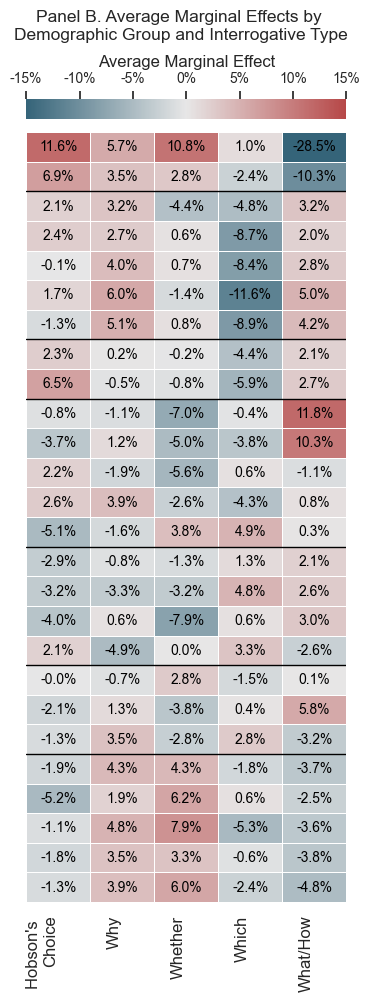

In [ ]:
########################################
# Format figure with average marginal effects 
########################################

# Toggle to include or exclude y-axis legends 
# (not included in final figure but useful for checking things are processed properly)
include_legends = False  # Set to False to hide y-axis tick labels and grey reference boxes

# (0) Figure label cleaning and reordering
clean_qtype_labels = {
    "whether_q": "Whether",
    "which_q": "Which",
    "why_q": "Why",
    "whathow_q": "What/How",
    "hobsons_c": "Hobson's \nChoice"
}

# (1) Reorder columns using clean_qtype_labels 
x_order = ["hobsons_c", "why_q", "whether_q", "which_q", "whathow_q"]
x_labels_clean = [clean_qtype_labels[q] for q in x_order]
effect_data = effect_data[x_order]
annotations = annotations[x_order]

# (b) Remove "Birth region: oceania" row from both dataframes (to avoid visual distortion because of small sample size / large magnitude)
row_to_remove = "Birth Region: Oceania"
effect_data = effect_data.drop(index=row_to_remove, errors="ignore")
annotations = annotations.drop(index=row_to_remove, errors="ignore")


# (2) Define custom diverging colormap
custom_div_cmap = LinearSegmentedColormap.from_list("custom_diverging", ["#356479", "#e7e7e7", "#B64747"], N=256) 
# custom_div_cmap = LinearSegmentedColormap.from_list("custom_div", ["#073B76DD", "#f7f7f7", "#7a0025e1"], N=256)

# (3) Layout control 
target_width_in = 4.13
cell_height = 0.9
max_height_in = 10
fig_height = min(len(effect_data.index) * cell_height + 1.5, max_height_in)

# (4) Create figure and top colorbar axis 
fig, ax = plt.subplots(figsize=(target_width_in, fig_height))
cbar_ax = fig.add_axes([
    ax.get_position().x0,
    ax.get_position().y1 + 0.013,
    ax.get_position().width,
    0.02
])

# (5) Plot heatmap 
vmin, vmax = -0.15, 0.15
hm = sns.heatmap(
    effect_data,
    annot=False,
    cmap=custom_div_cmap,
    center=0,
    vmin=vmin,
    vmax=vmax,
    linewidths=0.5,
    linecolor="white",
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal", "label": "Average Marginal Effect"},
    ax=ax
)

# (6) Overlay percent text (no bold) 
for y_idx, y_label in enumerate(effect_data.index):
    for x_idx, x_label in enumerate(effect_data.columns):
        val = annotations.loc[y_label, x_label]
        ax.text(
            x_idx + 0.5, y_idx + 0.5,
            val,
            ha="center", va="center",
            fontsize=10,
            fontweight="normal",
            color="black"
        )

# (7) Style colorbar 
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_label("Average Marginal Effect", size=12)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))

# (8) Axis labels 
ax.set_xticklabels(x_labels_clean, rotation=90, ha="right", fontsize=12)
if include_legends:
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
else:
    ax.set_yticklabels([])  # Hide y-axis tick labels
ax.set_xlabel(None)
ax.set_ylabel(None)

# (9) Group lines and reference text 
line_positions, y_positions, seen = [], {}, {}
# Rebuild demo_prefixes from the CURRENT index so boundaries are correct after row removal
demo_prefixes = [
    next((p for p in label_map if str(idx).startswith(label_map[p])), None)
    for idx in effect_data.index
]
for i, prefix in enumerate(demo_prefixes):
    if prefix not in seen:
        if seen:
            prev = list(seen.values())[-1]
            line_positions.append(i)
            y_positions[list(seen.keys())[-1]] = (prev + i - 1) / 2
        seen[prefix] = i
y_positions[demo_prefixes[-1]] = (seen[demo_prefixes[-1]] + len(demo_prefixes) - 1) / 2

for y in line_positions:
    ax.axhline(y=y, color='black', linewidth=1)

if include_legends:
    for prefix, y in y_positions.items():
        if prefix in ref_texts:
            ax.text(
                -0.9, y + 0.5,
                ref_texts[prefix],
                transform=ax.get_yaxis_transform(),
                rotation=90,
                va="center", ha="center",
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgrey", edgecolor="none"),
                clip_on=False
            )

# (10) Title 
fig.suptitle("Panel B. Average Marginal Effects by \nDemographic Group and Interrogative Type",
             fontsize=12.5, y=1.0025)

# (11) Save& show 
if to_save:
    save_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_2_panel_B.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


In [17]:
########################################
# Combine Figure 2 Panel A and Panel B PDFs side-by-side + add bottom title & note
########################################

# (0) Inputs 
fig_a_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_2_panel_A.pdf")
fig_b_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_2_panel_B.pdf")
combined_pdf_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "figure_2.pdf")

# (1) Poppler path if needed
poppler_path = os.environ.get("POPPLER_PATH", None)

# (2) Convert PDFs to images at 300 DPI 
kwargs = {"dpi": 300}
if poppler_path:
    kwargs["poppler_path"] = poppler_path

img_a = convert_from_path(fig_a_path, **kwargs)[0]
img_b = convert_from_path(fig_b_path, **kwargs)[0]

# (3) Match heights 
target_h = max(img_a.height, img_b.height)

def _resize_to_height(im, h):
    w = int(im.width * (h / im.height))
    return im.resize((w, h), Image.LANCZOS)

img_a = _resize_to_height(img_a, target_h)
img_b = _resize_to_height(img_b, target_h)


# (4) Concatenate with gutter 
gutter_px = 1
combined_w = img_a.width + gutter_px + img_b.width
combined_h = target_h

combined = Image.new("RGB", (combined_w, combined_h), "white")
combined.paste(img_a, (0, 0))
combined.paste(img_b, (img_a.width + gutter_px, 0))

# (5) Wrap in Matplotlib to add bottom title & note 
dpi = 300
bottom_margin_in = 2.3  # space for title + note
fig_w_in = combined_w / dpi
fig_h_in = combined_h / dpi + bottom_margin_in

fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in), dpi=dpi)
ax.axis("off")

# (6) Image placement
img_top = bottom_margin_in / fig_h_in
img_height = (combined_h / dpi) / fig_h_in
ax_img = fig.add_axes([0, img_top, 1, img_height])
ax_img.axis("off")
ax_img.imshow(combined)

# (7) Get left alignment based on Panel A's position 
left_x = ax_img.get_position().x0

# (8) Title (bold "Figure 2.") 
figure_title = r"$\bf{Figure\ 2.}$ Logistic Regression and Marginal Effects for Interrogative Types Across Explanatory Variables (Study 1)"
plt.figtext(
    left_x, 0.16,  # adjust y if needed
    figure_title,
    ha="left",
    va="bottom",
    fontsize=12.5,
    fontfamily="Arial"
)

# (9) Note 
note_text = (
    r"$\it{Note.}$ Panel A reports log odds from the specification described in §3.2.3, "
    "for each interrogative type across demographic subgroups. Positive values indicate greater odds of the outcome "
    "relative to the reference category. * indicates statistical significance at α = .01 (99% confidence level). "
    "Panel B presents the corresponding average marginal effects, expressed "
    "as percentage point changes in predicted probability. ‘Prefer not to say’ categories were retained in analyses "
    "but excluded from visualisations to avoid distortions from low cell counts."
)

plt.figtext(
    left_x, 0.08,  # below title
    note_text,
    ha="left",
    va="bottom",
    fontsize=12,
    linespacing=1.5,
    fontfamily="Arial",
    wrap=True
)

# (10) Save final PDF 
fig.savefig(combined_pdf_path, bbox_inches="tight", dpi=dpi)
plt.close(fig)

print(f"Saved combined PDF to: {combined_pdf_path}")

Saved combined PDF to: /Users/carolinewagner/Desktop/Local/MY498-capstone-main/03_outputs/02_descriptive_analyses/figure_2.pdf


#### 3.2 Appendix. Figure with predicted probabilities. 

In [112]:
########################################
# Data pre-processing for figure with pred probabilities
########################################

# (1) Remove all "Prefer not to say" terms from prediction_table (again)
prediction_table = prediction_table[~prediction_table["term"].str.contains("prefer not to say", case=False, na=False)]

# (2) Merge significance from previous model 
summary_table["significant_99pc"] = summary_table["adj_p"] < 0.01
sig_flags = summary_table[["term", "outcome", "significant_99pc"]].copy()

if "significant_99pc" in prediction_table.columns:
    prediction_table = prediction_table.drop(columns=["significant_99pc"])

prediction_table = prediction_table.merge(sig_flags, on=["term", "outcome"], how="left")
prediction_table["significant_99pc"] = prediction_table["significant_99pc"].astype("boolean").fillna(False)

# (3) Pivot data 
prob_data = prediction_table.pivot(index="term", columns="outcome", values="predicted_prob")
sig_data = prediction_table.pivot(index="term", columns="outcome", values="significant_99pc")

# (4) Remove accidental y-axis labels
prob_data.index.name = None
sig_data.index.name = None

# (5) Create percentage annotations 
annotations = prob_data.copy()
for col in annotations.columns:
    annotations[col] = annotations[col].apply(lambda x: f"{x:.1%}")
annotations.index.name = None

# (6) Clean and prettify labels 
clean_labels_dict = {}
demo_prefixes_raw = []
for term in prob_data.index:
    for prefix, label in label_map.items():
        if term.startswith(prefix):
            val_raw = term.replace(prefix, "").replace("_", " ").strip().lower()
            pretty_val = group_label_map.get(val_raw, val_raw.title())
            clean_label = f"{label}{pretty_val}"
            clean_labels_dict[term] = clean_label
            demo_prefixes_raw.append(prefix)
            break

prob_data.index = prob_data.index.map(clean_labels_dict)
annotations.index = annotations.index.map(clean_labels_dict)
sig_data.index = sig_data.index.map(clean_labels_dict)

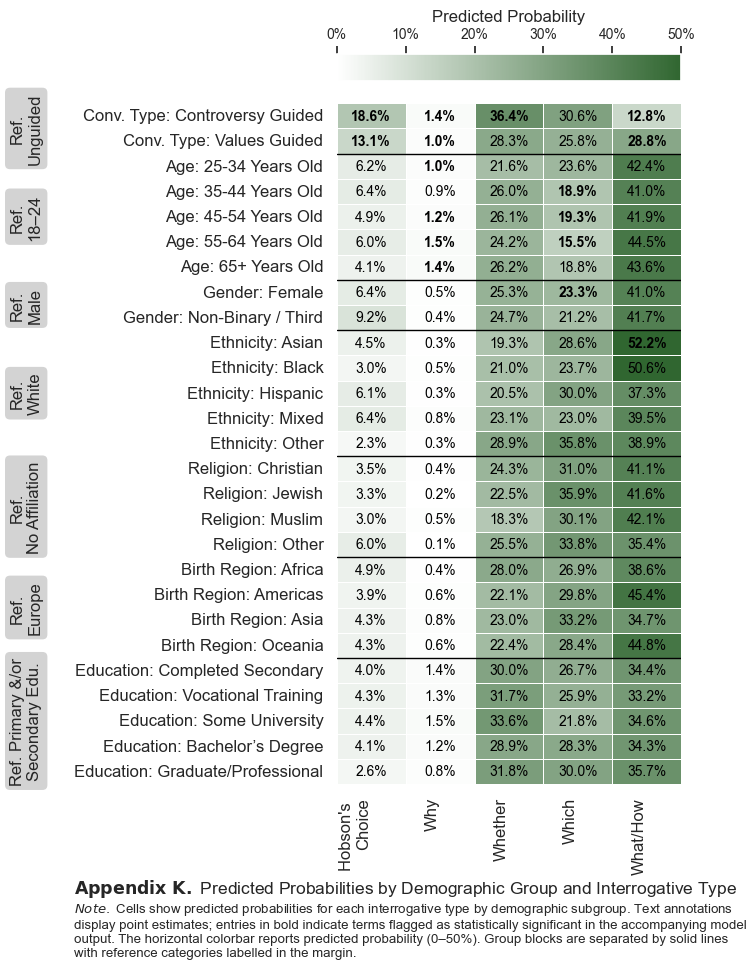

In [ ]:
########################################
# Predicted probabilities App. K 
########################################

# (1) Ordering 
ordered_terms = []
for group in demo_order:
    prefix = label_map[group]
    group_terms = [term for term in prob_data.index if term.startswith(prefix)]
    if group in row_ordering:
        custom_order = row_ordering[group]
        pretty_order = [group_label_map.get(v, v.title()) for v in custom_order]
        ordered = [f"{prefix}{v}" for v in pretty_order if f"{prefix}{v}" in group_terms]
        unordered = [term for term in group_terms if term not in ordered]
        group_terms = ordered + unordered
    ordered_terms.extend(group_terms)

prob_data = prob_data.loc[ordered_terms]
annotations = annotations.loc[ordered_terms]
sig_data = sig_data.loc[ordered_terms]

demo_prefixes = [next((p for p in label_map if label.startswith(label_map[p])), None)
                 for label in prob_data.index]

# (2) Columns & labels
prob_data   = prob_data[x_order]
annotations = annotations[x_order]
sig_data    = sig_data[x_order]
x_labels_clean = [clean_qtype_labels[q] for q in prob_data.columns]

# (3) Colormap
custom_green = LinearSegmentedColormap.from_list("custom_green", ["#ffffff", "#306630"], N=256)

# (4) Figure sizing (same visual size as before) 
target_width_in = 4.13
cell_height = 0.9
max_height_in = 10
fig_height = min(len(prob_data.index) * cell_height + 1.5, max_height_in)

fig, ax = plt.subplots(figsize=(target_width_in, fig_height))

# (5) Reserve space; keep bottom modest so plot doesn't shrink
plt.subplots_adjust(left=0.15, right=0.985, top=0.93, bottom=0.20)
fig.canvas.draw()

# (6) heatmap (no cbar yet) 
hm = sns.heatmap(
    prob_data, annot=False, cmap=custom_green,
    vmin=0, vmax=0.5, linewidths=0.5, linecolor="white",
    cbar=False, ax=ax
)

# (7) Top colorbar pinned close to the axis 
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="4%", pad=0.22)  # tighter gap than before
cb = plt.colorbar(hm.collections[0], cax=cax, orientation="horizontal")
cb.ax.tick_params(labelsize=10)
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.set_label("Predicted Probability", size=12)
cb.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0%}"))

# (8) Ticks & labels 
ax.set_xticklabels(x_labels_clean, rotation=90, ha="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xlabel(None); ax.set_ylabel(None)

# (9) Cell text annotations (bold if significant) 
for y_idx, y_label in enumerate(prob_data.index):
    for x_idx, x_label in enumerate(prob_data.columns):
        val = annotations.loc[y_label, x_label]
        is_sig = sig_data.loc[y_label, x_label]
        ax.text(x_idx + 0.5, y_idx + 0.5, val,
                ha="center", va="center", fontsize=10,
                fontweight=("bold" if is_sig else "normal"),
                color="black")

# (10) Group lines and reference labels 
line_positions, y_positions, seen = [], {}, {}
for i, prefix in enumerate(demo_prefixes):
    if prefix not in seen:
        if seen:
            prev = list(seen.values())[-1]
            line_positions.append(i)
            y_positions[list(seen.keys())[-1]] = (prev + i - 1) / 2
        seen[prefix] = i
last = demo_prefixes[-1]
y_positions[last] = (seen[last] + len(demo_prefixes) - 1) / 2

for y in line_positions:
    ax.axhline(y=y, color='black', linewidth=1)

for prefix, y in y_positions.items():
    if prefix in ref_texts:
        ax.text(-0.9, y + 0.5, ref_texts[prefix],
                transform=ax.get_yaxis_transform(),
                rotation=90, va="center", ha="center", fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgrey", edgecolor="none"),
                clip_on=False)

# (11) Bottom title & note aligned with start of y-axis labels 
fig.canvas.draw()
renderer = fig.canvas.get_renderer()
# find left edge of the leftmost y-tick label (in figure coords)
try:
    y_bbs = [lab.get_window_extent(renderer=renderer) for lab in ax.get_yticklabels()]
    left_x_fig = min(bb.x0 for bb in y_bbs) / fig.canvas.get_width_height()[0]
except Exception:
    # fallback: align to axes left if tick labels aren't rendered
    left_x_fig = ax.get_position().x0

title_y = 0.085
note_y  = 0.025 # smaller gap

# (12) Title 
bottom_title = r'$\bf{Appendix\ K.}$ Predicted Probabilities by Demographic Group and Interrogative Type'
plt.figtext(left_x_fig, title_y, bottom_title,
            ha='left', va='bottom', fontsize=12.5, fontfamily='Arial')

# (13) Note
note_text = (
    "$\\it{Note.}$ Cells show predicted probabilities for each interrogative type by demographic subgroup. "
    "Text annotations display point estimates; entries in bold indicate terms flagged as statistically significant in the "
    "accompanying model output. The horizontal colorbar reports predicted probability (0–50%). "
    "Group blocks are separated by solid lines with reference categories labelled in the margin."
)
plt.figtext(left_x_fig, note_y, note_text,
            ha='left', va='bottom', fontsize=9.5, fontfamily='Arial',
            linespacing=1.15, wrap=True)

# (14) Save 
if to_save:
    save_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "appendix_k.pdf")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

## 4. Implement clustering technique

In [ ]:
########################################
# Implement pre-registered clustering technique - this is not included in the final report; but described ni teh pre-registration accountability statement. 
########################################

# Aim to build the debiased proportion matrix
# (1) Define the debiased question type columns
debiased_question_cols = [
    "hobsons_c",
    "why_q",
    "whether_q",
    "which_q",
    "whathow_q"
]

# (2) Aggregate by user_id (instead of participant_id)
user_counts = classified_data.groupby("user_id")[debiased_question_cols].sum()

# (3) Convert to proportions
user_props = user_counts.div(user_counts.sum(axis=1), axis=0)

# (4) Drop users with no classified questions
user_props = user_props.dropna()

# (5)Preview
display(user_props.head())

# (6) Implement the clustering technique 

#  Pre-registered settings 
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=45,               # ≈ 0.5% of 8,011 participants or prompts
    min_samples=None,                  # Let HDBSCAN choose based on cluster size
    metric='euclidean',                # Default (valid for proportions)
    cluster_selection_method='eom',    # Default and recommended
    prediction_data=True               # Optional if you want outlier scores later
)

# (7) Run clustering 
user_props["cluster"] = clusterer.fit_predict(user_props)

# (8) Cluster distribution 
print(user_props["cluster"].value_counts())


,hobsons_c,why_q,whether_q,which_q,whathow_q
user_id,,,,,
user0,0.000000,0.000000,0.000000,0.0,1.000000
user1,0.000000,0.000000,0.166667,0.0,0.833333
user10,0.000000,0.166667,0.166667,0.0,0.666667
user100,0.000000,0.000000,0.400000,0.6,0.000000
user1001,0.166667,0.000000,0.833333,0.0,0.000000


cluster
-1    1103
 0     179
 2      55
 1      54
Name: count, dtype: int64


/opt/anaconda3/envs/capstone_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/capstone_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [23]:
cluster_profiles = user_props.groupby("cluster")[[
    "hobsons_c", "why_q", "whether_q", "which_q", "whathow_q"
]].mean()

display(cluster_profiles)


,hobsons_c,why_q,whether_q,which_q,whathow_q
cluster,,,,,
-1,0.129083,0.071092,0.282187,0.198094,0.319544
0,0.000000,0.000000,0.385821,0.261652,0.352527
1,0.000000,0.000000,0.498677,0.000000,0.501323
2,0.000000,0.000000,0.339394,0.000000,0.660606


/var/folders/1g/psqjshmj4y982_b569j0hptm0000gn/T/ipykernel_27405/2172857397.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for suptitle


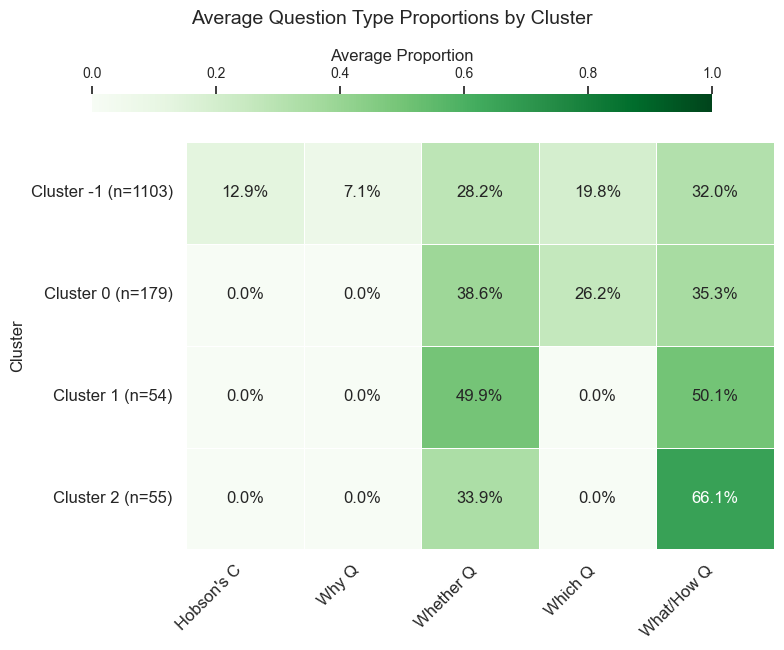

In [ ]:
# (1) Ensure column labels are cleaned 
x_labels_clean = ["Hobson's C", "Why Q", "Whether Q", "Which Q", "What/How Q"]
cluster_profiles.columns = x_labels_clean  # Rename if not already

# (2) Add cluster sizes to index labels — safely 
# Only relabel if current index is raw (e.g., integers like -1, 0, 1, ...)
cluster_counts = user_props["cluster"].value_counts().sort_index()

if all(isinstance(i, (int, np.integer)) for i in cluster_profiles.index):
    cluster_profiles.index = [
        f"Cluster {i} (n={cluster_counts.get(i, 0)})" for i in cluster_profiles.index
    ]

# (3) Set up figure 
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(top=0.85)  # Reserve space for title and colorbar

# (4) Top colorbar axes
cbar_ax = fig.add_axes([
    0.125,   # left
    0.91,    # bottom
    0.775,   # width
    0.03     # height
])

#  (5) Plot heatmap 
sns.heatmap(
    cluster_profiles,
    annot=True,
    fmt=".1%",           # Show values as percentages
    cmap="Greens",
    vmin=0, vmax=1,
    linewidths=0.5,
    linecolor="white",
    cbar_ax=cbar_ax,
    cbar_kws={"orientation": "horizontal", "label": "Average Proportion"},
    ax=ax
)

# (6) Axis styling 
ax.set_xticklabels(x_labels_clean, rotation=45, ha="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xlabel(None)
ax.set_ylabel("Cluster", fontsize=12)

# (7) Colorbar styling 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_label("Average Proportion", size=12)

# (8) Add centered title 
fig.suptitle("Average Question Type Proportions by Cluster", fontsize=14, y=1.08, ha="center")

# (9) Final layout 
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave room for suptitle

if to_save:
    save_path = os.path.join(DESCRIPTIVE_ANALYSIS_DIR, "05_clustered_question_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  

plt.show()
